In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_2019 = pd.read_csv("./data/yellow_tripdata_2019.csv")
zone = pd.read_csv("./data/taxi_zones_xy.csv")

# The most pickups and drop offs region

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df = df_2019[["PULocationID", "DOLocationID"]]
df = df.mask(df > 263)
df = df.mask(df < 1)
df = df.dropna().sample(n=20000)
# df = df.dropna().sample(n=10000)

## K-means, DBSCAN

Silhouette Coefficient Pickup: 0.481
Silhouette Coefficient Drop off: 0.408


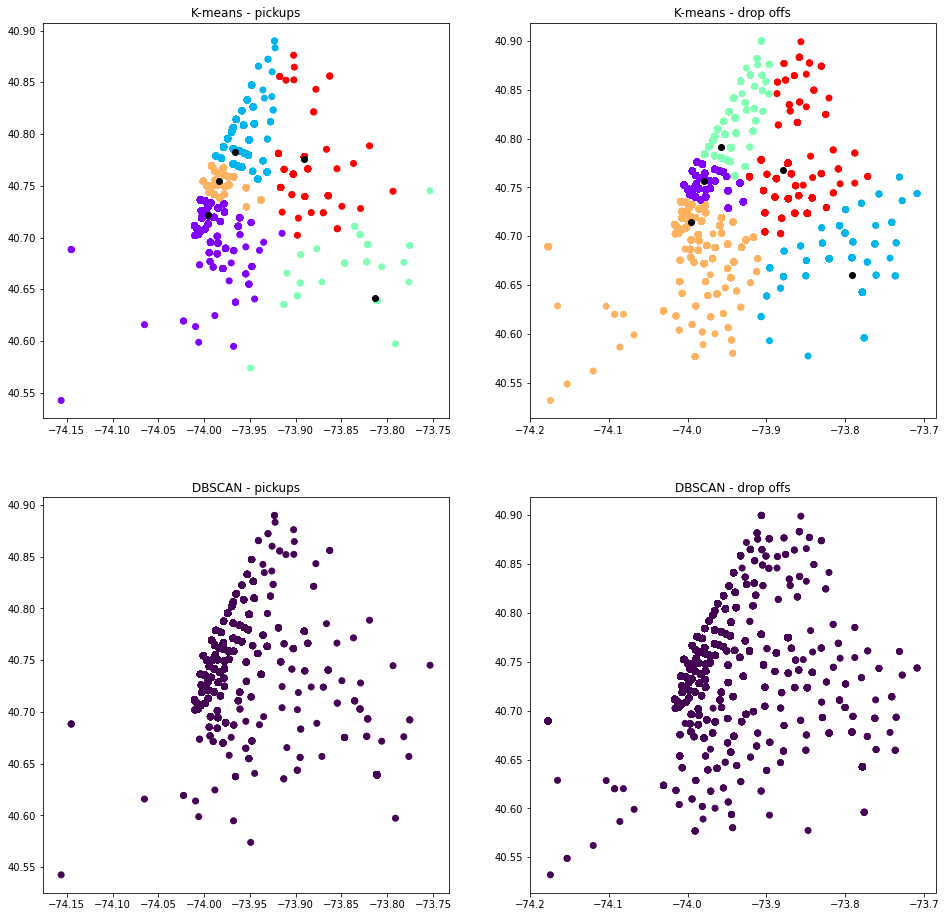

In [3]:
pickup = df["PULocationID"].to_frame()
dropoff = df["DOLocationID"].to_frame()


pickup = pickup.join(zone.set_index("LocationID"), on = "PULocationID")
dropoff = dropoff.join(zone.set_index("LocationID"), on = "DOLocationID")

x_pickup = pickup.drop(columns = ["PULocationID", "zone", "borough"]).values
x_dropoff = dropoff.drop(columns = ["DOLocationID", "zone", "borough"]).values

std = StandardScaler()
x_pickup = std.fit_transform(x_pickup)
x_dropoff = std.fit_transform(x_dropoff)
k_means_pickup = KMeans(n_clusters = 5).fit(x_pickup)
k_means_dropoff = KMeans(n_clusters = 5).fit(x_dropoff)
x_pickup = std.inverse_transform(x_pickup)
x_dropoff = std.inverse_transform(x_dropoff)

print("Silhouette Coefficient Pickup: %0.3f" % metrics.silhouette_score(x_pickup, k_means_pickup.labels_))
print("Silhouette Coefficient Drop off: %0.3f" % metrics.silhouette_score(x_dropoff, k_means_dropoff.labels_))

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 16))

ax = plt.subplot(2, 2, 1)
ax.set_title("K-means - pickups")
plt.scatter(x_pickup[:, 0], x_pickup[:, 1], c = k_means_pickup.labels_, cmap = 'rainbow', zorder = 2)
centers_pikup = std.inverse_transform(k_means_pickup.cluster_centers_)
plt.scatter(centers_pikup[:, 0], centers_pikup[:, 1], color = 'black', zorder = 3)

ax = plt.subplot(2, 2, 2)
ax.set_title("K-means - drop offs")
plt.scatter(x_dropoff[:, 0], x_dropoff[:, 1], c = k_means_dropoff.labels_, cmap = 'rainbow', zorder = 2)
centers_dropoff = std.inverse_transform(k_means_dropoff.cluster_centers_)
plt.scatter(centers_dropoff[:, 0], centers_dropoff[:, 1], color = 'black', zorder = 3)

ax = plt.subplot(2, 2, 3)
ax.set_title("DBSCAN - pickups")
dbscan_pikup = DBSCAN(eps = 0.3, min_samples = 10).fit(x_pickup)
plt.scatter(x_pickup[:,0], x_pickup[:,1], c = dbscan_pikup.labels_)

ax = plt.subplot(2, 2, 4)
ax.set_title("DBSCAN - drop offs")
dbscan_dropoff = DBSCAN(eps = 0.3, min_samples = 10).fit(x_dropoff)
plt.scatter(x_dropoff[:,0], x_dropoff[:,1], c = dbscan_dropoff.labels_)

plt.show()

#  The peak hours and off-peak hours

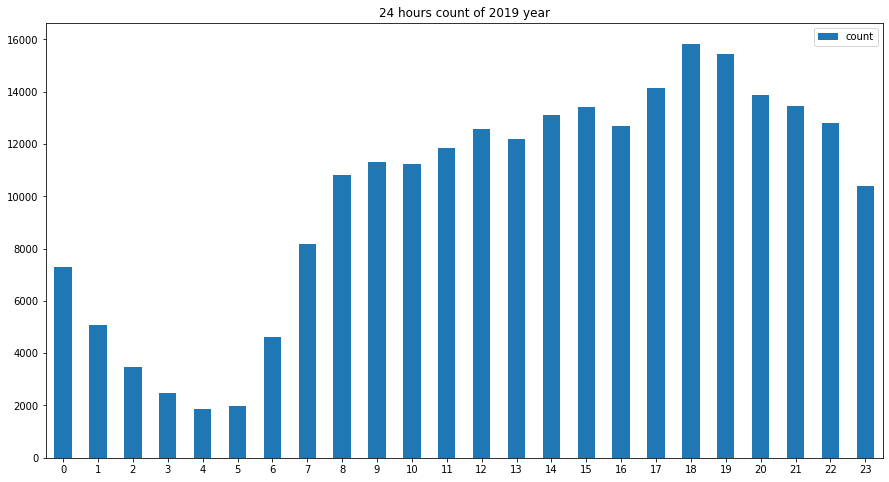

In [4]:
pickup_hour = df_2019["tpep_pickup_datetime"].map \
    (lambda x: int(x.split(" ")[1].split(":")[0])).value_counts().to_frame() \
    .sort_index().rename(columns = {"tpep_pickup_datetime": "count"})

dropoff_hour = df_2019["tpep_dropoff_datetime"].map \
    (lambda x: int(x.split(" ")[1].split(":")[0])).value_counts().to_frame() \
    .sort_index().rename(columns = {"tpep_dropoff_datetime": "count"})

df_hours = pickup_hour.add(dropoff_hour)

df_hours.plot.bar(rot = 0, title = "24 hours count of 2019 year", figsize=(15,8))

# Differences between short and long distance trips

Q1 is : 3.05 
Q2 is : 1.63 
Q3 is : 0.98


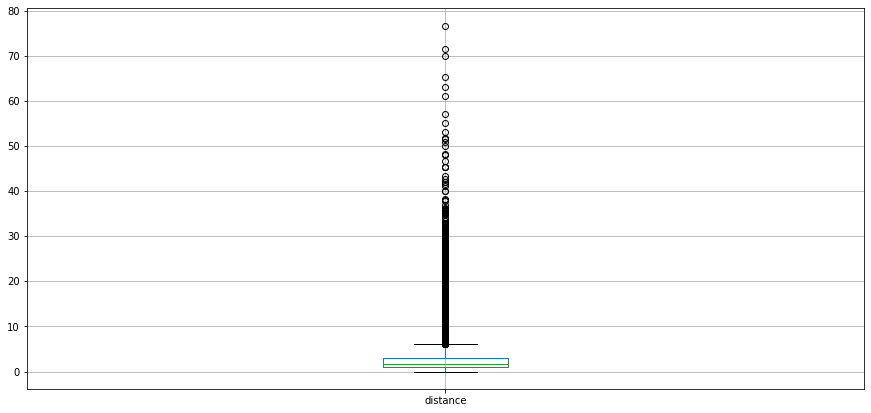

In [5]:
distance = df_2019["trip_distance"].to_frame() \
    .rename(columns = {"trip_distance": "distance"}).sort_values(by = ["distance"])
quartile = np.percentile(distance, [25, 50, 75])

fig,axes = plt.subplots(figsize = (15, 7))
Q1 = quartile[2]
Q2 = quartile[1]
Q3 = quartile[0]
print("Q1 is : {} \nQ2 is : {} \nQ3 is : {}".format(Q1, Q2, Q3))
distance.boxplot(column = ["distance"])

In [6]:
long_distance = (distance >= Q1).sort_index().rename(columns = {"distance": "long_distance"})
short_distance = (distance <= Q3).sort_index().rename(columns = {"distance": "short_distance"})
pickup_time = df_2019["tpep_pickup_datetime"].map \
    (lambda x: int(x.split(" ")[1].split(":")[0])).to_frame() \
    .sort_index().rename(columns = {"tpep_pickup_datetime": "pickup_time"})

dropoff_time = df_2019["tpep_dropoff_datetime"].map \
    (lambda x: int(x.split(" ")[1].split(":")[0])).to_frame() \
    .sort_index().rename(columns = {"tpep_dropoff_datetime": "dropoff_time"})
info_df = pd.concat([df_2019[["PULocationID", "DOLocationID"]], \
                     short_distance, long_distance, pickup_time, dropoff_time], axis = 1)


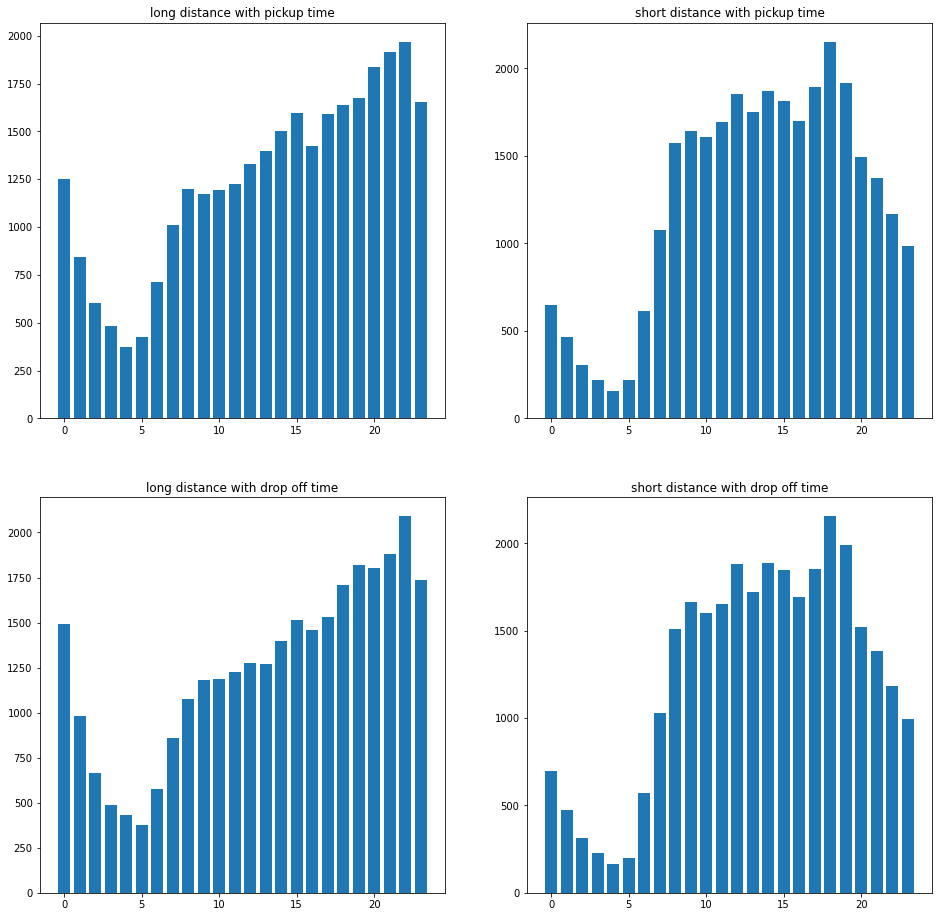

In [7]:
time = np.unique(info_df["pickup_time"])
long_distance_pickup = info_df[["long_distance", "pickup_time"]].groupby(["long_distance", "pickup_time"]).size()[1]
short_distance_pickup = info_df[["short_distance", "pickup_time"]].groupby(["short_distance", "pickup_time"]).size()[1]
long_distance_dropoff = info_df[["long_distance", "dropoff_time"]].groupby(["long_distance", "dropoff_time"]).size()[1]
short_distance_dropoff = info_df[["short_distance", "dropoff_time"]].groupby(["short_distance", "dropoff_time"]).size()[1]



fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 16))

ax = plt.subplot(2, 2, 1)
ax.set_title("long distance with pickup time")
plt.bar(time, long_distance_pickup)

ax = plt.subplot(2, 2, 2)
ax.set_title("short distance with pickup time")
plt.bar(time, short_distance_pickup)

ax = plt.subplot(2, 2, 3)
ax.set_title("long distance with drop off time")
plt.bar(time, long_distance_dropoff)

ax = plt.subplot(2, 2, 4)
ax.set_title("short distance with drop off time")
plt.bar(time, short_distance_dropoff)

plt.show()
